In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers
!pip install datasets
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# train_data = train_data.select(range(200))
# test_data = test_data.select(range(100))

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
from tqdm import tqdm

logging.basicConfig(level=logging.ERROR)

In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
TRAIN_SIZE = 0.8
LEARNING_RATE = 1e-05
STEP = 100
LABELS = ['World', 'Sports', 'Business', 'Sci/Tech']
NUM_CLASSES = len(LABELS)
TOKENIZER = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, NUM_CLASSES)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return torch.softmax(output, dim=1)

In [ ]:
class NewsData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
dataset_dict = load_dataset("ag_news")

test_data = pd.DataFrame(dataset_dict['train'])
# test_data = test_data.head(100)
train_data = pd.DataFrame(dataset_dict['test'])
# train_data = train_data.head(100)

print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = NewsData(train_data, TOKENIZER, MAX_LEN)
testing_set = NewsData(test_data, TOKENIZER, MAX_LEN)

  0%|          | 0/2 [00:00<?, ?it/s]

TRAIN Dataset: (7600, 2)
TEST Dataset: (120000, 2)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
model = RobertaClass()
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [ ]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    confusionMatrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            predicted = [torch.argmax(x).item() for x in outputs]
            # print(targets.shape, len(predicted))
            trueClass = targets.tolist()
            for trueClassLabel, predictedClassLabel in zip(trueClass, predicted):
                confusionMatrix[trueClassLabel, predictedClassLabel] = confusionMatrix[trueClassLabel, predictedClassLabel] + 1

            if _%STEP==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                # print(f"Validation Loss per 100 steps: {loss_step}")
                # print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu, epoch_loss, confusionMatrix

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()

    confusionMatrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        
        predicted = [torch.argmax(x).item() for x in outputs]
        # print("DEBUG", targets.shape, len(predicted), targets, predicted)
        trueClass = targets.tolist()
        for trueClassLabel, predictedClassLabel in zip(trueClass, predicted):
            confusionMatrix[trueClassLabel, predictedClassLabel] = confusionMatrix[trueClassLabel, predictedClassLabel] + 1

        
        if _%STEP==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            # print(f"Training Loss per 5000 steps: {loss_step}")
            # print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")
    return epoch_accu, epoch_loss, confusionMatrix

In [ ]:
best_acc = 0
best_model = model
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss, train_cnf_mtx = train(epoch)
    print("Accuracy on test data = %0.2f%%" % train_acc)
    test_acc, test_loss, test_cnf_mtx = valid(model, testing_loader)
    print("Accuracy on test data = %0.2f%%" % test_acc)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    if test_acc > best_acc:
      # test_acc = best_acc
      # best_model  = model
      PATH = "/content/drive/MyDrive/GSU Coursework/NLP/project/model/"
      output_model_file = PATH + 'pytorch_roberta_news_' + str(epoch) + '.bin'
      output_vocab_file = PATH + './'

      # model_to_save = best_model
      torch.save(model, output_model_file)
      TOKENIZER.save_vocabulary(output_vocab_file)

      print('All files saved')
      print('This tutorial is completed')

  0%|          | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(

1it [00:01,  1.94s/it]
2it [00:03,  1.49s/

The Total Accuracy for Epoch 0: 77.25
Training Loss Epoch: 0.9960734884278113
Training Accuracy Epoch: 77.25
Accuracy on test data = 77.25%



0it [00:00, ?it/s]
1it [00:00,  2.21it/s]
2it [00:00,  2.21it/s]
3it [00:01,  2.22it/s]
4it [00:01,  2.22it/s]
5it [00:02,  2.21it/s]
6it [00:02,  2.21it/s]
7it [00:03,  2.22it/s]
8it [00:03,  2.23it/s]
9it [00:04,  2.25it/s]
10it [00:04,  2.26it/s]
11it [00:04,  2.26it/s]
12it [00:05,  2.27it/s]
13it [00:05,  2.27it/s]
14it [00:06,  2.27it/s]
15it [00:06,  2.28it/s]
16it [00:07,  2.28it/s]
17it [00:07,  2.28it/s]
18it [00:07,  2.28it/s]
19it [00:08,  2.28it/s]
20it [00:08,  2.28it/s]
21it [00:09,  2.28it/s]
22it [00:09,  2.28it/s]
23it [00:10,  2.28it/s]
24it [00:10,  2.28it/s]
25it [00:11,  2.28it/s]
26it [00:11,  2.28it/s]
27it [00:11,  2.27it/s]
28it [00:12,  2.27it/s]
29it [00:12,  2.25it/s]
30it [00:13,  2.23it/s]
31it [00:13,  2.21it/s]
32it [00:14,  2.21it/s]
33it [00:14,  2.20it/s]
34it [00:15,  2.20it/s]
35it [00:15,  2.20it/s]
36it [00:16,  2.20it/s]
37it [00:16,  2.19it/s]
38it [00:16,  2.21it/s]
39it [00:17,  2.23it/s]
40it [00:17,  2.25it/s]
41it [00:18,  2.26it/s]
42it 

Validation Loss Epoch: 0.8450212356090545
Validation Accuracy Epoch: 90.10166666666667
Accuracy on test data = 90.10%


 33%|███▎      | 1/3 [32:51<1:05:42, 1971.34s/it]

All files saved
This tutorial is completed



0it [00:00, ?it/s]
1it [00:01,  1.31s/it]
2it [00:02,  1.27s/it]
3it [00:03,  1.26s/it]
4it [00:05,  1.26s/it]
5it [00:06,  1.26s/it]
6it [00:07,  1.25s/it]
7it [00:08,  1.25s/it]
8it [00:10,  1.25s/it]
9it [00:11,  1.25s/it]
10it [00:12,  1.25s/it]
11it [00:13,  1.25s/it]
12it [00:15,  1.25s/it]
13it [00:16,  1.25s/it]
14it [00:17,  1.25s/it]
15it [00:18,  1.26s/it]
16it [00:20,  1.25s/it]
17it [00:21,  1.25s/it]
18it [00:22,  1.25s/it]
19it [00:23,  1.26s/it]
20it [00:25,  1.26s/it]
21it [00:26,  1.26s/it]
22it [00:27,  1.26s/it]
23it [00:28,  1.26s/it]
24it [00:30,  1.25s/it]
25it [00:31,  1.26s/it]
26it [00:32,  1.26s/it]
27it [00:33,  1.26s/it]
28it [00:35,  1.26s/it]
29it [00:36,  1.26s/it]
30it [00:37,  1.25s/it]
31it [00:38,  1.26s/it]
32it [00:40,  1.26s/it]
33it [00:41,  1.26s/it]
34it [00:42,  1.25s/it]
35it [00:43,  1.25s/it]
36it [00:45,  1.25s/it]
37it [00:46,  1.25s/it]
38it [00:47,  1.25s/it]
39it [00:48,  1.25s/it]
40it [00:50,  1.25s/it]
41it [00:51,  1.25s/it]
42it 

The Total Accuracy for Epoch 1: 90.71052631578948
Training Loss Epoch: 0.8392503299132115
Training Accuracy Epoch: 90.71052631578948
Accuracy on test data = 90.71%



0it [00:00, ?it/s]
1it [00:00,  2.21it/s]
2it [00:00,  2.22it/s]
3it [00:01,  2.23it/s]
4it [00:01,  2.24it/s]
5it [00:02,  2.25it/s]
6it [00:02,  2.25it/s]
7it [00:03,  2.26it/s]
8it [00:03,  2.26it/s]
9it [00:03,  2.27it/s]
10it [00:04,  2.27it/s]
11it [00:04,  2.26it/s]
12it [00:05,  2.27it/s]
13it [00:05,  2.27it/s]
14it [00:06,  2.27it/s]
15it [00:06,  2.26it/s]
16it [00:07,  2.25it/s]
17it [00:07,  2.24it/s]
18it [00:08,  2.22it/s]
19it [00:08,  2.21it/s]
20it [00:08,  2.20it/s]
21it [00:09,  2.19it/s]
22it [00:09,  2.19it/s]
23it [00:10,  2.19it/s]
24it [00:10,  2.22it/s]
25it [00:11,  2.24it/s]
26it [00:11,  2.25it/s]
27it [00:12,  2.25it/s]
28it [00:12,  2.26it/s]
29it [00:12,  2.26it/s]
30it [00:13,  2.26it/s]
31it [00:13,  2.27it/s]
32it [00:14,  2.27it/s]
33it [00:14,  2.27it/s]
34it [00:15,  2.27it/s]
35it [00:15,  2.27it/s]
36it [00:16,  2.27it/s]
37it [00:16,  2.27it/s]
38it [00:16,  2.27it/s]
39it [00:17,  2.27it/s]
40it [00:17,  2.27it/s]
41it [00:18,  2.27it/s]
42it 

Validation Loss Epoch: 0.8380627324581146
Validation Accuracy Epoch: 90.60083333333333
Accuracy on test data = 90.60%


 67%|██████▋   | 2/3 [1:05:46<32:53, 1973.49s/it]

All files saved
This tutorial is completed



0it [00:00, ?it/s]
1it [00:01,  1.28s/it]
2it [00:02,  1.26s/it]
3it [00:03,  1.25s/it]
4it [00:05,  1.25s/it]
5it [00:06,  1.25s/it]
6it [00:07,  1.26s/it]
7it [00:08,  1.26s/it]
8it [00:10,  1.25s/it]
9it [00:11,  1.25s/it]
10it [00:12,  1.25s/it]
11it [00:13,  1.25s/it]
12it [00:15,  1.25s/it]
13it [00:16,  1.25s/it]
14it [00:17,  1.25s/it]
15it [00:18,  1.25s/it]
16it [00:20,  1.25s/it]
17it [00:21,  1.26s/it]
18it [00:22,  1.26s/it]
19it [00:23,  1.26s/it]
20it [00:25,  1.26s/it]
21it [00:26,  1.26s/it]
22it [00:27,  1.25s/it]
23it [00:28,  1.25s/it]
24it [00:30,  1.25s/it]
25it [00:31,  1.26s/it]
26it [00:32,  1.26s/it]
27it [00:33,  1.26s/it]
28it [00:35,  1.26s/it]
29it [00:36,  1.25s/it]
30it [00:37,  1.26s/it]
31it [00:38,  1.26s/it]
32it [00:40,  1.25s/it]
33it [00:41,  1.25s/it]
34it [00:42,  1.25s/it]
35it [00:43,  1.25s/it]
36it [00:45,  1.25s/it]
37it [00:46,  1.26s/it]
38it [00:47,  1.26s/it]
39it [00:49,  1.27s/it]
40it [00:50,  1.27s/it]
41it [00:51,  1.27s/it]
42it 

The Total Accuracy for Epoch 2: 91.4342105263158
Training Loss Epoch: 0.8295846937083396
Training Accuracy Epoch: 91.4342105263158
Accuracy on test data = 91.43%



0it [00:00, ?it/s]
1it [00:00,  2.23it/s]
2it [00:00,  2.23it/s]
3it [00:01,  2.24it/s]
4it [00:01,  2.21it/s]
5it [00:02,  2.23it/s]
6it [00:02,  2.24it/s]
7it [00:03,  2.24it/s]
8it [00:03,  2.23it/s]
9it [00:04,  2.25it/s]
10it [00:04,  2.25it/s]
11it [00:04,  2.26it/s]
12it [00:05,  2.26it/s]
13it [00:05,  2.25it/s]
14it [00:06,  2.25it/s]
15it [00:06,  2.24it/s]
16it [00:07,  2.23it/s]
17it [00:07,  2.23it/s]
18it [00:08,  2.22it/s]
19it [00:08,  2.20it/s]
20it [00:08,  2.19it/s]
21it [00:09,  2.20it/s]
22it [00:09,  2.21it/s]
23it [00:10,  2.21it/s]
24it [00:10,  2.23it/s]
25it [00:11,  2.23it/s]
26it [00:11,  2.24it/s]
27it [00:12,  2.25it/s]
28it [00:12,  2.25it/s]
29it [00:12,  2.26it/s]
30it [00:13,  2.26it/s]
31it [00:13,  2.26it/s]
32it [00:14,  2.26it/s]
33it [00:14,  2.26it/s]
34it [00:15,  2.26it/s]
35it [00:15,  2.26it/s]
36it [00:16,  2.27it/s]
37it [00:16,  2.26it/s]
38it [00:16,  2.26it/s]
39it [00:17,  2.26it/s]
40it [00:17,  2.25it/s]
41it [00:18,  2.25it/s]
42it 

Validation Loss Epoch: 0.8524410324255626
Validation Accuracy Epoch: 89.07166666666667
Accuracy on test data = 89.07%


100%|██████████| 3/3 [1:38:40<00:00, 1973.60s/it]

All files saved
This tutorial is completed


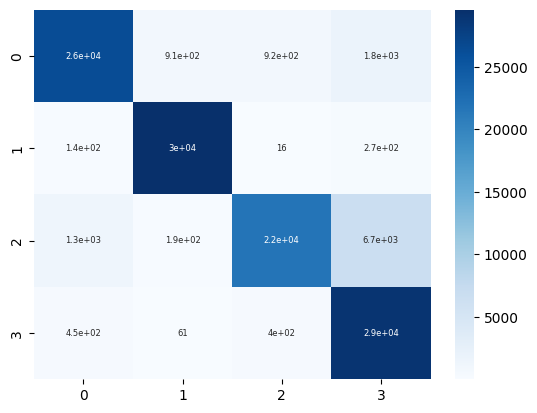

In [ ]:
sns.heatmap(test_cnf_mtx, annot=True, cmap='Blues', annot_kws={"size": 6})
plt.show()

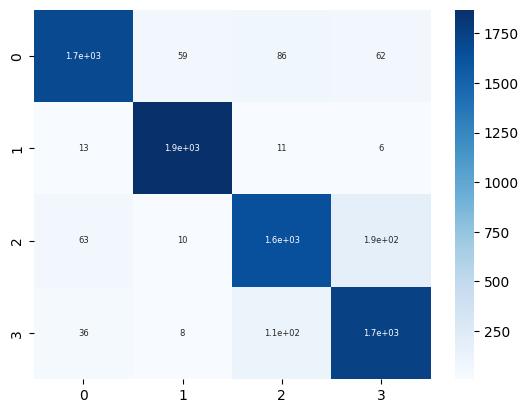

In [ ]:
sns.heatmap(train_cnf_mtx, annot=True, cmap='Blues', annot_kws={"size": 6})
plt.show()

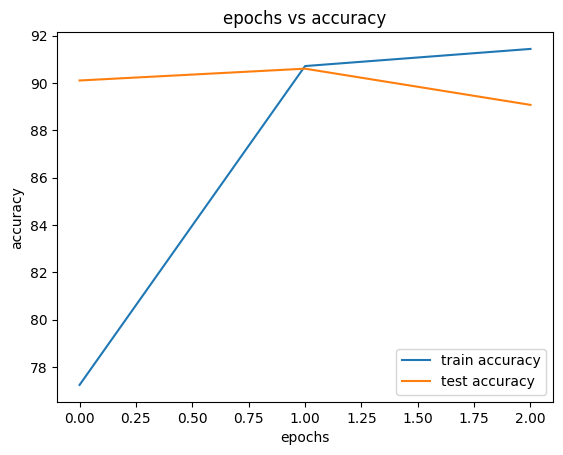

In [ ]:
x = [x for x in range(len(train_acc_list))]
plt.plot(x, train_acc_list, label='train accuracy')
plt.plot(x, test_acc_list, label='test accuracy')
plt.title('epochs vs accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

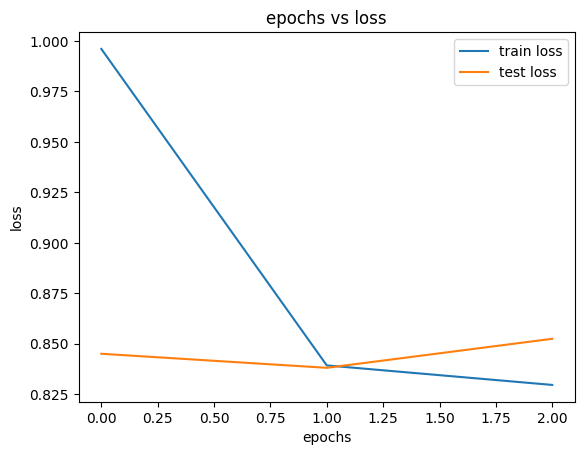

In [ ]:
x = [x for x in range(len(train_acc_list))]
plt.plot(x, train_loss_list, label='train loss')
plt.plot(x, test_loss_list, label='test loss')
plt.title('epochs vs loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()